In [61]:
import pandas as pd
import numpy as np

1. Exploratory Data Analysis (EDA)

In [62]:
data = pd.read_csv("creditcard.csv")
display(data.describe())
print(data.columns)
print(data["Class"].value_counts())
print("Proportion of frauds (1s): ", (sum(data["Class"] == 1))/len(data))
print("Proportion of legit (0s): ", (sum(data["Class"] == 0))/len(data))


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Class
0    284315
1       492
Name: count, dtype: int64
Proportion of frauds (1s):  0.001727485630620034
Proportion of legit (0s):  0.9982725143693799


2. Unsupervised learning (Isolation Forest)

In [63]:
# features
X = data.filter(regex="^V")
Y = data["Class"]

In [64]:
# import libraries
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [65]:
# build model
isolationForest = IsolationForest(random_state=42)
isolationForest.fit(X)
isolationForest_predictions = isolationForest.predict(X)

In [66]:
# in isolation forest, -1 = anomaly, 1 = normal, so change to match class label
iso_predictions_df = pd.DataFrame({"Class": isolationForest_predictions})
iso_predictions_df["Class"] = iso_predictions_df["Class"].map({-1:1, 1:0})

In [67]:
# results
iso_class_report = classification_report(Y, iso_predictions_df["Class"], output_dict=True)
iso_matrix = confusion_matrix(Y, iso_predictions_df["Class"])
print(iso_class_report)
print(iso_matrix)
print(iso_predictions_df["Class"].value_counts())

{'0': {'precision': 0.9996765306641662, 'recall': 0.9674234563776093, 'f1-score': 0.9832855786950561, 'support': 284315.0}, '1': {'precision': 0.04169684428349715, 'recall': 0.8191056910569106, 'f1-score': 0.07935414000196908, 'support': 492.0}, 'accuracy': 0.9671672395692522, 'macro avg': {'precision': 0.5206866874738316, 'recall': 0.89326457371726, 'f1-score': 0.5313198593485126, 'support': 284807.0}, 'weighted avg': {'precision': 0.9980216345215178, 'recall': 0.9671672395692522, 'f1-score': 0.981724050123648, 'support': 284807.0}}
[[275053   9262]
 [    89    403]]
Class
0    275142
1      9665
Name: count, dtype: int64


3. Supervised learning (Random Forest)

In [68]:
# import libraries
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [69]:
# train model using cross validation
randomForest = RandomForestClassifier()
cv = KFold(n_splits=5, shuffle=True, random_state=42)
random_forest_scores = cross_val_score(randomForest, X, Y, scoring='accuracy')
random_forest_predictions = cross_val_predict(randomForest, X, Y, cv=cv)
randomForest.fit(X, Y)

RandomForestClassifier()

In [70]:
# results
random_forest_report = classification_report(Y, random_forest_predictions, output_dict=True)
random_forest_matrix = confusion_matrix(Y, random_forest_predictions)
print("Cross-validation scores: ", random_forest_scores)
print("Mean accuracy: ", np.mean(random_forest_scores))
print("Standard deviation: ", np.std(random_forest_scores))
print(random_forest_report)
print(random_forest_matrix)
print("Proportion of RFC frauds (1)", np.sum(random_forest_predictions==0)/len(random_forest_predictions))
print("Proportion of RFC legits (0)", np.sum(random_forest_predictions==1)/len(random_forest_predictions))
print(pd.DataFrame({"Class": random_forest_predictions}).value_counts())

Cross-validation scores:  [0.99912222 0.99957867 0.99915732 0.99963133 0.99943821]
Mean accuracy:  0.9993855490567641
Standard deviation:  0.00021066796236339397
{'0': {'precision': 0.999620257170283, 'recall': 0.9999296554877513, 'f1-score': 0.9997749323918005, 'support': 284315.0}, '1': {'precision': 0.9504950495049505, 'recall': 0.7804878048780488, 'f1-score': 0.8571428571428571, 'support': 492.0}, 'accuracy': 0.9995505728440663, 'macro avg': {'precision': 0.9750576533376167, 'recall': 0.8902087301829, 'f1-score': 0.9284588947673288, 'support': 284807.0}, 'weighted avg': {'precision': 0.9995353940799399, 'recall': 0.9995505728440663, 'f1-score': 0.9995285375313424, 'support': 284807.0}}
[[284295     20]
 [   108    384]]
Proportion of RFC frauds (1) 0.9985814955390844
Proportion of RFC legits (0) 0.0014185044609156376
Class
0        284403
1           404
Name: count, dtype: int64


4. Analysis of the 2 models

In [71]:
# In the context of credit card fraud detection

# Recall: True positive rate
# Recall measures the proportion of actual fraud cases (positive instances) that the model correctly identifies as fraud. Minimises false negatives (fraud classified as legit)
# Precision: Positive prediction value
# Precision Precision measures the proportion of predicted fraud cases (the positive predictions) that are actually fraudulent. Minimises false positives (legit classied as fraud)

# We want to priorities higher recall as if failure to detect fraud can have bigger consequences, 
# compared to precision where client transactions which are false positives can generally be remedied
# Accuracy is not a good measure due to high class imbalance

In [72]:
# Visualisation of effectiveness of the 2 methods
import matplotlib.pyplot as plt

In [79]:
iso_anomaly_data = iso_class_report['1']
random_anomaly_data = random_forest_report['1']

# precision
iso_precision = iso_anomaly_data["precision"]
random_precision = random_anomaly_data["precision"]

# recall
iso_recall = iso_anomaly_data["recall"]
random_recall = random_anomaly_data["recall"]

# f1-score
iso_f1_score = iso_anomaly_data["f1-score"]
random_f1_score = random_anomaly_data["f1-score"]

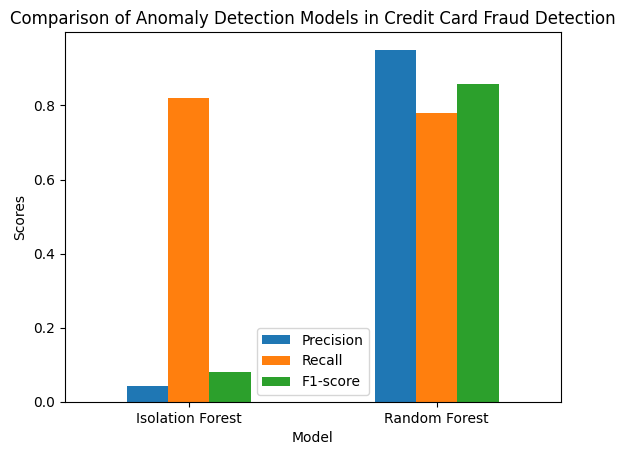

In [94]:
# Graph 1
anomaly_data = pd.DataFrame({"Model": ["Isolation Forest", "Random Forest"], "Precision": [iso_precision, random_precision], 
                             "Recall": [iso_recall, random_recall], "F1-score": [iso_f1_score, random_f1_score]})
anomaly_data.set_index("Model").plot(kind='bar')

plt.title("Comparison of Anomaly Detection Models in Credit Card Fraud Detection")
plt.ylabel("Scores")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.show()

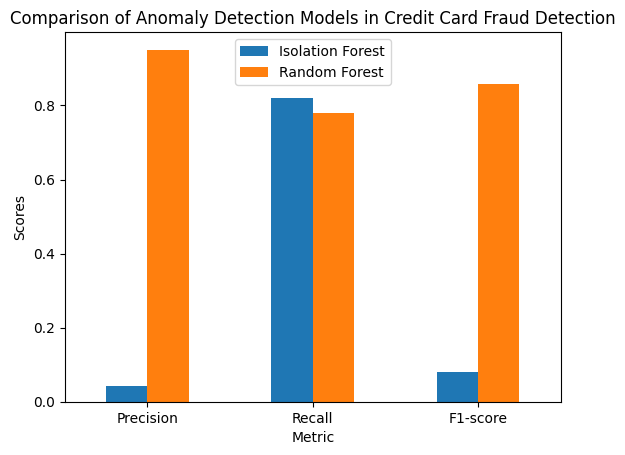

In [95]:
# Graph 2
anomaly_data_2 = pd.DataFrame({"Metrics": ["Precision", "Recall", "F1-score"], "Isolation Forest": [iso_precision, iso_recall, iso_f1_score], 
                               "Random Forest": [random_precision, random_recall, random_f1_score]})
anomaly_data_2.set_index("Metrics").plot(kind='bar')

plt.title("Comparison of Anomaly Detection Models in Credit Card Fraud Detection")
plt.ylabel("Scores")
plt.xlabel("Metric")
plt.xticks(rotation=0)
plt.show()